# NYC COVID-19 Case

This notebook will focus on bringing data from COVID-19 Cases in NYC, mapping it, and then potentially linking it to the isochrones. 

## Bringing in the COVID-19 Data 

In [1]:
import plotly.express as px
import pandas as pd
import geopandas as gpd

import contextily as ctx
import matplotlib.pyplot as plt


from shapely import wkt



 First, I will read the raw data from [NYC Health-Github page](https://github.com/laharps/up206-groupproject/blob/main/Final%20Project/Notebooks/Isochrone%20Analysis.ipynb). I will also do some initial data exploration, including looking at the variables in the data, the data types, etc. 

In [2]:
ny_covid= pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/totals/data-by-modzcta.csv')
ny_covid.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,1012,3664.93,27613.09,27,97.78,6.28,16345
1,10002,Chinatown/Lower East Side,Manhattan,3851,5112.67,75322.71,199,264.20,9.80,39835
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,1779,3295.80,53977.81,37,68.55,4.93,36711
3,10004,Financial District,Manhattan,191,6426.40,2972.12,2,67.29,6.28,3072
4,10005,Financial District,Manhattan,271,3094.59,8757.23,0,0.00,5.16,5178


Okay, great, the data looks pretty well structured. I do notice that there is both a case count and case rate. I'll be using the case rate since that adjust for population size. It's nice that they have the data so clean! However, it also seems like there is no geographical information with the data, so I'll have to merge it with a ZCTA shapefile before mapping it. 


Now to do some more exploration to learn about the varaible times, examining if there are any missing values in the data, etc. 

In [3]:
ny_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MODIFIED_ZCTA      177 non-null    int64  
 1   NEIGHBORHOOD_NAME  177 non-null    object 
 2   BOROUGH_GROUP      177 non-null    object 
 3   COVID_CASE_COUNT   177 non-null    int64  
 4   COVID_CASE_RATE    177 non-null    float64
 5   POP_DENOMINATOR    177 non-null    float64
 6   COVID_DEATH_COUNT  177 non-null    int64  
 7   COVID_DEATH_RATE   177 non-null    float64
 8   PERCENT_POSITIVE   177 non-null    float64
 9   TOTAL_COVID_TESTS  177 non-null    int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 14.0+ KB


Okay, great, now I know that there are 177 rows and ten columns on the data. I am going to run a random sample to see if any of the data seems weird.

In [4]:
ny_covid.sample(10)

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
139,11368,Corona/North Corona,Queens,8667,7852.69,110369.78,467,423.12,15.29,57511
62,10457,Belmont/Claremont/Mount Hope/Tremont,Bronx,5144,6977.61,73721.56,206,279.43,14.27,37094
97,11210,Flatlands/Midwood,Brooklyn,4144,6308.71,65687.01,177,269.46,14.24,29401
121,11235,Brighton Beach/Manhattan Beach/Sheepshead Bay,Brooklyn,6727,8602.56,78197.62,381,487.23,16.98,40942
4,10005,Financial District,Manhattan,271,3094.59,8757.23,0,0.00,5.16,5178
52,10309,Charleston/Prince's Bay/Woodrow,Staten Island,3068,9314.03,32939.56,47,142.69,16.65,18803
50,10307,Tottenville,Staten Island,1313,8804.90,14912.16,21,140.82,16.53,8012
100,11213,Crown Heights (East),Brooklyn,3490,5402.37,64601.26,161,249.22,11.47,30954
130,11358,Auburndale/Murray Hill,Queens,1741,4832.81,36024.61,56,155.45,10.03,17602
18,10022,East Midtown,Manhattan,1147,3712.43,30896.18,40,129.47,5.69,20441


I am going to do a quick histogram to look at the distribution of the data.

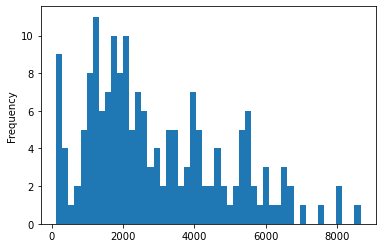

In [5]:
ny_covid['COVID_CASE_COUNT'].plot.hist(bins=50)

Okay, now I am going to verify there are no missing values for the covid-19 data. 

In [6]:
ny_covid.COVID_CASE_RATE.value_counts()

4485.76    1
6320.95    1
7518.31    1
8183.71    1
6594.81    1
          ..
7151.42    1
7499.63    1
5402.37    1
3662.74    1
5227.78    1
Name: COVID_CASE_RATE, Length: 177, dtype: int64

In [7]:
print(ny_covid['COVID_CASE_RATE'].isnull().value_counts())

False    177
Name: COVID_CASE_RATE, dtype: int64


YAY! No null values. Okay, now it's time to merge the COVID-19 case data with a ZCTA shapefile, well, more specifically, a modified ZCTA shapefile. Thankfully the [NYC Health-Github page](https://github.com/nychealth/coronavirus-data/tree/master/Geography-resources) provides a modified ZCTA shapefile.

In [8]:
modified_ZCTA= gpd. read_file('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/Geography-resources/MODZCTA_2010_WGS1984.geo.json')
modified_ZCTA.head()

,MODZCTA,label,geometry
0,10001,"10001, 10118","POLYGON ((-73.98774 40.74407, -73.98504 40.747..."
1,10002,10002,"POLYGON ((-73.99750 40.71407, -73.99730 40.713..."
2,10003,10003,"POLYGON ((-73.98864 40.72293, -73.98843 40.723..."
3,10004,10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00801 ..."
4,10005,10005,"POLYGON ((-74.00783 40.70309, -74.00619 40.704..."


The label for row zero seems a bit weird seems it contains both 10001 and 10118. However, it might indicate how the two ZCTAs were combined. I will do a little more exploring like I did with the COVID-19 case data and then map if I find anything wrong with the data. 

In [9]:
modified_ZCTA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   MODZCTA   178 non-null    object  
 1   label     178 non-null    object  
 2   geometry  178 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 4.3+ KB


Okay, so there is one more entry for in this data set than in the COVID-19 data. I am not really sure how to identify which additional ZCTA exist in this database.

In [10]:
modified_ZCTA.sample(20)

,MODZCTA,label,geometry
50,10307,10307,"MULTIPOLYGON (((-74.22184 40.50254, -74.22166 ..."
27,10031,10031,"POLYGON ((-73.96000 40.82039, -73.95985 40.820..."
94,11207,11207,"POLYGON ((-73.90348 40.67551, -73.90344 40.675..."
108,11221,11221,"POLYGON ((-73.91604 40.68607, -73.91464 40.687..."
11,10013,10013,"POLYGON ((-74.01286 40.71718, -74.01163 40.716..."
91,11204,11204,"POLYGON ((-73.97300 40.60881, -73.97348 40.611..."
126,11354,11354,"POLYGON ((-73.80752 40.76218, -73.80733 40.763..."
138,11367,11367,"POLYGON ((-73.82567 40.71615, -73.82525 40.716..."
158,11419,11419,"POLYGON ((-73.83175 40.67954, -73.82949 40.680..."
119,11233,11233,"POLYGON ((-73.92424 40.66645, -73.92222 40.667..."


In [11]:
print(modified_ZCTA['geometry'].isnull().value_counts())

False    178
Name: geometry, dtype: int64


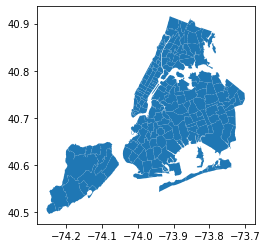

In [12]:
modified_ZCTA.plot()

Okay great! Seems to have all of NYC. I am going to merge the dataset so I can plot the COVID-19 Case Data. 

First, I need to rename the column name of one of the two datasets.

In [13]:
ny_covid=   ny_covid.rename(columns={'MODIFIED_ZCTA':'MODZCTA'})
ny_covid.head()

,MODZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,1012,3664.93,27613.09,27,97.78,6.28,16345
1,10002,Chinatown/Lower East Side,Manhattan,3851,5112.67,75322.71,199,264.20,9.80,39835
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,1779,3295.80,53977.81,37,68.55,4.93,36711
3,10004,Financial District,Manhattan,191,6426.40,2972.12,2,67.29,6.28,3072
4,10005,Financial District,Manhattan,271,3094.59,8757.23,0,0.00,5.16,5178


Now I also have to make sure that the MODZCTA column type matches in both datasets. I am going to transform the variable from the modified_ZCTA database to an integer.

In [14]:
modified_ZCTA['MODZCTA']= modified_ZCTA['MODZCTA'].astype(str).astype(int)
modified_ZCTA.dtypes

MODZCTA        int64
label         object
geometry    geometry
dtype: object

In [15]:
modified_ZCTA.head()

,MODZCTA,label,geometry
0,10001,"10001, 10118","POLYGON ((-73.98774 40.74407, -73.98504 40.747..."
1,10002,10002,"POLYGON ((-73.99750 40.71407, -73.99730 40.713..."
2,10003,10003,"POLYGON ((-73.98864 40.72293, -73.98843 40.723..."
3,10004,10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00801 ..."
4,10005,10005,"POLYGON ((-74.00783 40.70309, -74.00619 40.704..."


In [16]:
nyc_covid_mzcta= modified_ZCTA.merge(ny_covid, on='MODZCTA')
nyc_covid_mzcta.head(5)

,MODZCTA,label,geometry,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,"10001, 10118","POLYGON ((-73.98774 40.74407, -73.98504 40.747...",Chelsea/NoMad/West Chelsea,Manhattan,1012,3664.93,27613.09,27,97.78,6.28,16345
1,10002,10002,"POLYGON ((-73.99750 40.71407, -73.99730 40.713...",Chinatown/Lower East Side,Manhattan,3851,5112.67,75322.71,199,264.20,9.80,39835
2,10003,10003,"POLYGON ((-73.98864 40.72293, -73.98843 40.723...",East Village/Gramercy/Greenwich Village,Manhattan,1779,3295.80,53977.81,37,68.55,4.93,36711
3,10004,10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00801 ...",Financial District,Manhattan,191,6426.40,2972.12,2,67.29,6.28,3072
4,10005,10005,"POLYGON ((-74.00783 40.70309, -74.00619 40.704...",Financial District,Manhattan,271,3094.59,8757.23,0,0.00,5.16,5178


In [17]:
nyc_covid_mzcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 177 entries, 0 to 176
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   MODZCTA            177 non-null    int64   
 1   label              177 non-null    object  
 2   geometry           177 non-null    geometry
 3   NEIGHBORHOOD_NAME  177 non-null    object  
 4   BOROUGH_GROUP      177 non-null    object  
 5   COVID_CASE_COUNT   177 non-null    int64   
 6   COVID_CASE_RATE    177 non-null    float64 
 7   POP_DENOMINATOR    177 non-null    float64 
 8   COVID_DEATH_COUNT  177 non-null    int64   
 9   COVID_DEATH_RATE   177 non-null    float64 
 10  PERCENT_POSITIVE   177 non-null    float64 
 11  TOTAL_COVID_TESTS  177 non-null    int64   
dtypes: float64(4), geometry(1), int64(4), object(3)
memory usage: 18.0+ KB


Okay, great! There seem to be 177 cases total (what we had in the orginial NY COVID CASE dataset.)

also, first I am going to check the CRS since this is mapping info. 

In [18]:
nyc_covid_mzcta.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Okay great. Now I now that the data is in espg:4326. Now I reproject these coordinates to web mercator.

In [19]:
nyc_covid_mzcta = nyc_covid_mzcta.to_crs(epsg=3857)
nyc_covid_mzcta.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Okay, it appears that there is some ZCTA's with missing info, which was sort of expected since there were more rows in the modified_zcta database. However, there seem to be multi areas with missing variables, not just one. This likely is caused due to low data numbers in those areas.

Now, I am going to map the covid 19 Case Count data. However, I think I am unsure about what scheme is best for dividing the data. For now,I am going to create three version of the maps one with quantile breaks, another with equal break, and finally natural breaks. From the histogram I ran earlier, it doesn't seem the data is evenly distributed, so natural breaks might end up being the best option for displaying the data. For some more reading about this, we will reference [this](http://webhelp.esri.com/arcgisdesktop/9.2/index.cfm?TopicName=Classification_methods). 

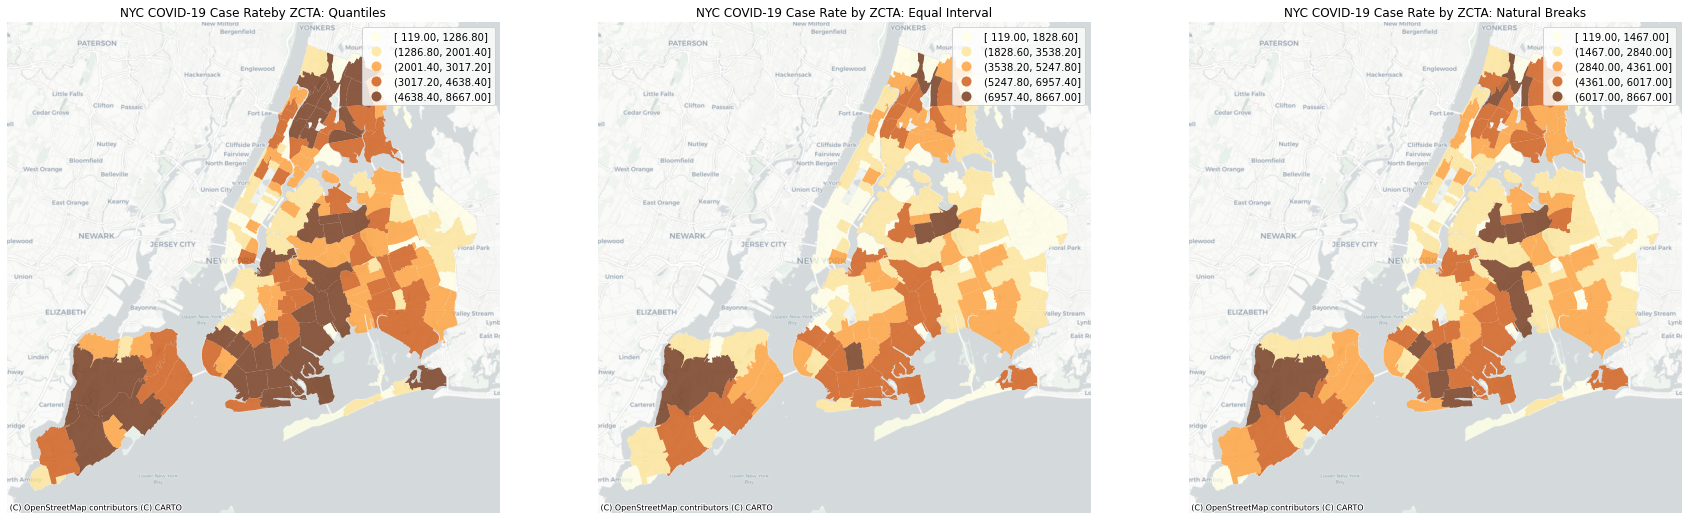

In [20]:
fig, axs=plt.subplots(1, 3, figsize=(30,20))

ax1, ax2, ax3 = axs

nyc_covid_mzcta.plot(
               column='COVID_CASE_COUNT',
                legend=True,
                cmap='YlOrBr',
                scheme='quantiles',
                edgecolor='white',
                linewidth=0.,
                alpha=0.75,
                ax=ax1)

ax1.axis("off")
ax1.set_title("NYC COVID-19 Case Rateby ZCTA: Quantiles")
ctx.add_basemap(ax=ax1,source=ctx.providers.CartoDB.Positron)


nyc_covid_mzcta.plot(
               column='COVID_CASE_COUNT',
                legend=True,
                cmap='YlOrBr',
                scheme='equalinterval',
                k=5,
                edgecolor='white',
                linewidth=0.,
                alpha=0.75,
                ax=ax2)

ax2.axis("off")
ax2.set_title("NYC COVID-19 Case Rate by ZCTA: Equal Interval")
ctx.add_basemap( ax=ax2,source=ctx.providers.CartoDB.Positron)


nyc_covid_mzcta.plot(
               column='COVID_CASE_COUNT',
                legend=True,
                cmap='YlOrBr',
                scheme='naturalbreaks',
                edgecolor='white',
                linewidth=0.,
                alpha=0.75,
                ax=ax3)

ax3.axis("off")
ax3.set_title("NYC COVID-19 Case Rate by ZCTA: Natural Breaks")
ctx.add_basemap(ax=ax3,source=ctx.providers.CartoDB.Positron)





In [21]:
from keplergl import KeplerGl

In our original proposal, we had indicated dividing the data into quintiles to determine neighborhoods that are hardest hit by COVID-19; however, it appears we have to do further analysis to determine which method is best for defying "hardest-hit neighborhoods". 

Now, I will save the database for further analysis. Ideally, we will be rerunning this notebook every time we want to conduct research using the COVID-19 case rate data to pull the most recent COVID-19 cases. 

In [22]:
nyc_covid_mzcta.to_file('nyc_covid_mzcta.geojson')